In [1]:
# imports
import numpy as np

# https://arxiv.org/pdf/1706.04599

### What is the point of calibration?

* Ensure that predicted probalitilies match real world outcomes
* I.e. if a nn cannot confidently predict 1 or 0 for obstructions, the car sensor should rely more on the output of other sensors for braking

#### Definitions

Define **perfect calibration** as $ P(\hat{y} = y | \hat{p} = p) = p  $ 

The calibration $\hat{p}=p$ cannot be computed with finitely many samples since $\hat{p}$ is a continuous random variable.

If we have **perfect calibration** then a **reliability diagram** which plots the confidence $\hat{p}$ on the x axis and the accuracy $P(\hat{y} = y | \hat{p} = p)$ on the left should plot the identity function, a diagonal line, $y=x$.

To compute a **reliability diagram**, we bin samples based on their confidence, and calculate the accuracy of each bin, given that we also have $[0,1]$ labels.

In [2]:
"""
generate n x 3 data where 

col_1 is the calibration p, can generate uniformly between (0,1)
col_2 is the label y
col_3 is the predicted label y, so flip col_2 w.p. 1-p

How can we do a bit flip in python?

0 --> 1: 0 + 1 mod 2
1 --> 0: 1 + 1 mod 2

so generate the second operand as a binomial w.p. 1-p
"""

import random

N = 100


def binomialvariate(n,p):
    return sum(random.random() < p for i in range(n))

col_1 = [random.uniform(0,1) for _ in range(N)]
y = [random.randint(0,1) for _ in range(N)]
coin_flip = [binomialvariate(n=1,p=1-proba) for proba in col_1]

y_hat = [(x + y)% 2 for x,y in zip(y,coin_flip)]

data_array = np.array([col_1, y, y_hat])
data_array = data_array.T

In [3]:
# create M = 10 bins for [0,1] interval?
# create list(range(11)) = [0,1,...,9] = buckets 
# each data point is >= lower_bound and < upper_bound

# so if data point is in bucket[i] then data_point >= bucket_[i] and < bucket_[i+1]
# min bucket[i] where data_point is greater than bucket[i]

In [4]:
# sort by col_1, the confidence

# col_1 looks like [0.22, ..., 0.44]
# multiply by 10 then round down
# bucket_assignment = math.floor(item * 10)
import math

bins = [math.floor(item*10) for item in col_1]
# print(bins)

bins = np.array(bins)

idxs = np.argwhere(bins==9)

# col_1, y, y_hat
# data_array ....

accs = []

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # index into y, y_hat to calculate per bin accuracies
    y_bucket = data_array[idxs,1]
    y_hat_bucket = data_array[idxs,2]

    equals = y_bucket == y_hat_bucket
    acc = np.mean(equals)
    accs.append(acc)

In [5]:
print(accs)

[0.16666666666666666, 0.125, 0.09090909090909091, 0.2, 0.5833333333333334, 0.5384615384615384, 0.5, 0.8461538461538461, 0.7777777777777778, 1.0]


In [6]:
buckets = list(range(10))

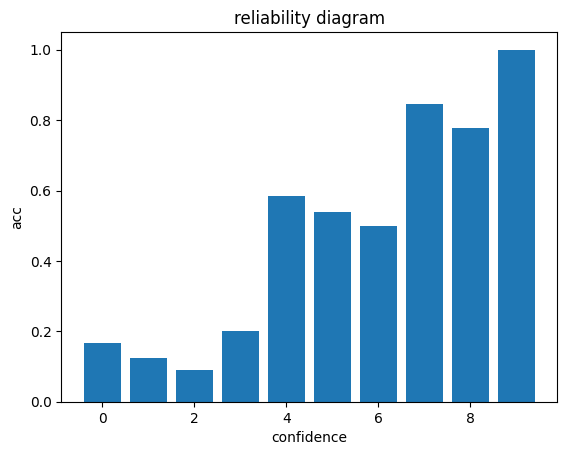

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(buckets, accs, label=buckets)
ax.set_ylabel('acc')
ax.set_xlabel('confidence')
ax.set_title('reliability diagram')

plt.show()

### Expected Calibration Error (ECE)

Prefer to have a scalar over a diagram

$ECE = \mathbb{E}_{\hat{p}} [\lvert P(\hat{y} = y | \hat{p} - p\rvert] = \sum_{m=1}^M \frac{\lvert B_m \rvert}{n} \vert acc(B_m) - conf(B_m) \vert $

In [8]:
# col_conf, y, y_hat
# data_array ....

ece = 0

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # index into y, y_hat to calculate per bin accuracies
    y_bucket = data_array[idxs,1]
    y_hat_bucket = data_array[idxs,2]

    equals = y_bucket == y_hat_bucket
    acc = np.mean(equals)
    bucket_size = len(idxs)
    conf = np.mean(data_array[idxs,0])
    ece += float(bucket_size/N) * abs(acc-conf)

print(ece)

0.09872878390324835


### What are some other ways to calibrate?

NLL, i.e. cross entropy loss, $ - \sum_{p(x)} \log q(x) $ , (Bengio et al 2015). According to (Friedman et al 2001), NLL is minimized iff $\hat{\pi}(y \vert x)$ recovers the ground truth conidtional distribution $\pi(y \vert x)$.

In practice, NLL, diverges from accuracy (Zhang et al 2017) so it is not a great calibration method in practice. 

### Platt Scaling and generalization to MultiClass Problems

What is **Platt scaling** (Platt et al, 1999)?
# https://home.cs.colorado.edu/~mozer/Teaching/syllabi/6622/papers/Platt1999.pdf

* A parametric approach to calibration
* The non-probabilistic predictions of a classifier are used as features for a logistic regression model, which is trained on the validation set to return probabilities
* I.e., learn $\hat{q_i} = \sigma(a z_i + b)$ as the calibrated probability using NLL over the validation set, while the NN parameters are fixed

### Matrix and vector scaling

* two multi-class extensions of Platt scaling. Apply linear transformation before the softmax
* $\hat{q_i} = max_k \sigma_{SM}(W z_i + b)$
* $\hat{y_i'} = argmax_k \sigma_{SM}(W z_i + b)$

* The parameters $W$ and $b$ are optimized wrt to NLL on the validation set.

In [9]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [11]:
print(type(testset[0]))
print(len(testset))
print(testset[0])

<class 'tuple'>
10000
(tensor([[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
         [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
         [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
         ...,
         [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
         [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
         [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],

        [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
         [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
         [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
         ...,
         [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
         [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
         [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],

        [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
         [-0.6000, -0.

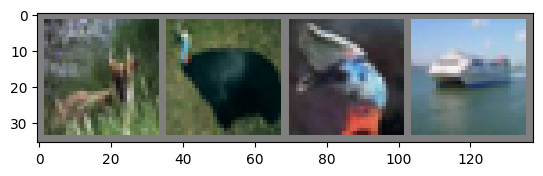

deer  bird  bird  ship 


In [12]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network

TODO(annhe): figure out how to calculate cnn inner layer dims

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.164
[1,  4000] loss: 1.767
[1,  6000] loss: 1.645
[1,  8000] loss: 1.576
[1, 10000] loss: 1.525
[1, 12000] loss: 1.483
[2,  2000] loss: 1.409
[2,  4000] loss: 1.371
[2,  6000] loss: 1.346
[2,  8000] loss: 1.330
[2, 10000] loss: 1.301
[2, 12000] loss: 1.315
[3,  2000] loss: 1.222
[3,  4000] loss: 1.233
[3,  6000] loss: 1.211
[3,  8000] loss: 1.207
[3, 10000] loss: 1.215
[3, 12000] loss: 1.185
[4,  2000] loss: 1.134
[4,  4000] loss: 1.131
[4,  6000] loss: 1.113
[4,  8000] loss: 1.133
[4, 10000] loss: 1.123
[4, 12000] loss: 1.103
Finished Training


In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # print(outputs.data.shape)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 59 %


In [18]:
# Freeze params of the CNN

for param in net.parameters():
    param.requires_grad = False

In [19]:
# define a new net, call it PlattNet

class PlattNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.matrix = nn.Linear(10, 10)

    def forward(self, x):
        x = self.matrix(x)
        x = F.softmax(x,dim=1)
        return x

plattnet = PlattNet()

for param in plattnet.parameters():
    param.requires_grad = True

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(plattnet.parameters(), lr=0.001, momentum=0.9)

In [21]:
for epoch in range(10):  # loop over the validation dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = plattnet(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Calibration')

[1,  2000] loss: 2.184
[2,  2000] loss: 1.978
[3,  2000] loss: 1.921
[4,  2000] loss: 1.905
[5,  2000] loss: 1.896
[6,  2000] loss: 1.889
[7,  2000] loss: 1.884
[8,  2000] loss: 1.880
[9,  2000] loss: 1.877
[10,  2000] loss: 1.874
Finished Calibration


In [22]:
print(testset[0][0].shape)

torch.Size([3, 32, 32])


In [23]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

In [24]:
for param in plattnet.parameters():
    param.requires_grad = False

In [25]:
histogram_x = []
histogram_y = []

In [32]:
for epoch in range(1):  # loop over the validation dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = plattnet(outputs)
        outputs = outputs.detach().numpy()
        labels = labels.detach().numpy()
        histogram_x.append(outputs)
        histogram_y.append(labels)
        

        if i % 1000 == 0: print("data point: ", i)

print('Finished Collecting Calibrated Points')

data point:  0
data point:  1000
data point:  2000
data point:  3000
data point:  4000
data point:  5000
data point:  6000
data point:  7000
data point:  8000
data point:  9000
Finished Collecting Calibrated Points


In [27]:
print(histogram_x[0][0])

[1.4693351e-03 3.2905060e-05 2.2335697e-02 3.4881055e-01 5.6641754e-03
 6.0621148e-01 1.3811648e-02 8.3522650e-04 7.7641394e-04 5.2567844e-05]


In [28]:
res = np.max(histogram_x[0][0])
print(res)

0.6062115


<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[nan, 0.0, 0.10810810810810811, 0.20823798627002288, 0.3074866310160428, 0.3808139534883721, 0.4129979035639413, 0.48330058939096265, 0.5834068843777581, 0.8140770252324038]
[0, 0.0, 0.10810810810810811, 0.20823798627002288, 0.3074866310160428, 0.3808139534883721, 0.4129979035639413, 0.48330058939096265, 0.5834068843777581, 0.8140770252324038]


/Users/annhe/anaconda3/envs/agency/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/annhe/anaconda3/envs/agency/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


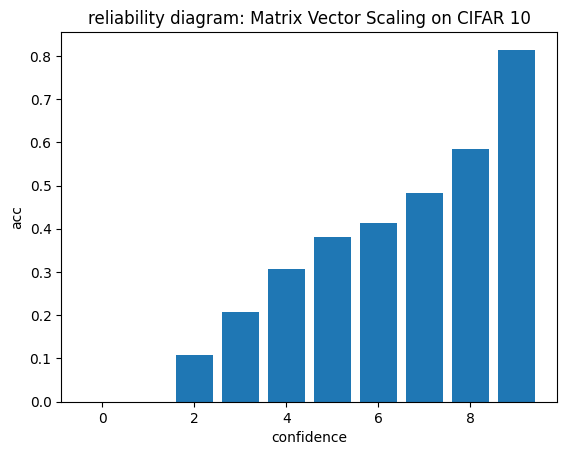

In [29]:
predicted_confidence = [np.max(x[0]) for x in histogram_x]
predicted_class = [np.argmax(x[0]) for x in histogram_x]
y_gt_label = [x[0] for x in histogram_y]

bins = [math.floor(item*10) for item in predicted_confidence]
bins = np.array(bins)
print(type(bins))
print(type(predicted_class))
predicted_class = np.array(predicted_class)
print(type(predicted_class))
y_gt_label = np.array(y_gt_label)
print(type(y_gt_label))

accs = []

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # print("bin idxs: ", bin, idxs)
    # index into y, y_hat to calculate per bin accuracies
    y_preds = predicted_class[idxs]
    y_gt = y_gt_label[idxs]

    equals = y_preds == y_gt
    acc = np.mean(equals)
    accs.append(acc)

print(accs)
accs = [0 if math.isnan(x) else x for x in accs]
print(accs)

buckets = list(range(10))

fig, ax = plt.subplots()

ax.bar(buckets, accs, label=buckets)
ax.set_ylabel('acc')
ax.set_xlabel('confidence')
ax.set_title('reliability diagram: Matrix Vector Scaling on CIFAR 10')

plt.show()

### Temperature Scaling

* A single parameter $T > 0$
* Given the logit vector $z_i$, the confidence prediction is $\hat{q_i} = \max_k \sigma_{SM}(z_i/T)$

In [30]:
temperature_x = {}
T_values = [1,2,50,100]
for t_value in T_values:
    temperature_x[t_value] = []

for t_value in T_values:
    for epoch in range(1):  # loop over the validation dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # forward + backward + optimize
            outputs = net(inputs)
            outputs /= t_value
            # print(outputs.shape)
            outputs = F.softmax(outputs,dim=1)
            #outputs = plattnet(outputs)
            outputs = outputs.detach().numpy()
            #labels = labels.detach().numpy()
            temperature_x[t_value].append(outputs)
            #histogram_y.append(labels)
        

        if i % 100 == 0: print("data point: ", i)

print('Finished Collecting Calibrated Points')

Finished Collecting Calibrated Points


[nan, 0.18292682926829268, 0.2616136919315403, 0.3333333333333333, 0.4205801104972376, 0.5278900565885206, 0.5980304386750224, 0.7172619047619048, 0.8205607476635514, 0.9259868421052632]
[0, 0.18292682926829268, 0.2616136919315403, 0.3333333333333333, 0.4205801104972376, 0.5278900565885206, 0.5980304386750224, 0.7172619047619048, 0.8205607476635514, 0.9259868421052632]


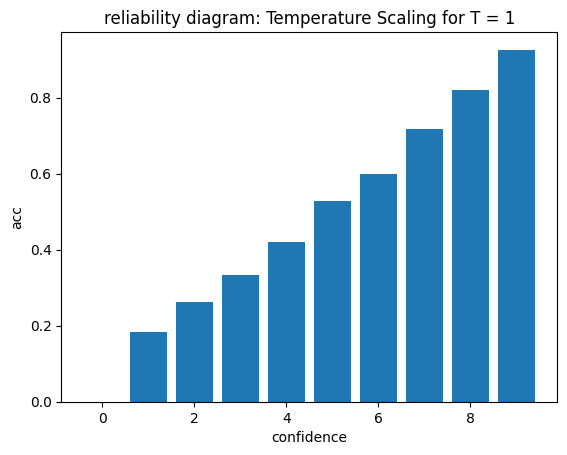

[nan, 0.24826789838337182, 0.3860759493670886, 0.5445221445221445, 0.6822953114065781, 0.798728813559322, 0.8561549100968188, 0.9240986717267552, 0.96, 0.9951219512195122]
[0, 0.24826789838337182, 0.3860759493670886, 0.5445221445221445, 0.6822953114065781, 0.798728813559322, 0.8561549100968188, 0.9240986717267552, 0.96, 0.9951219512195122]


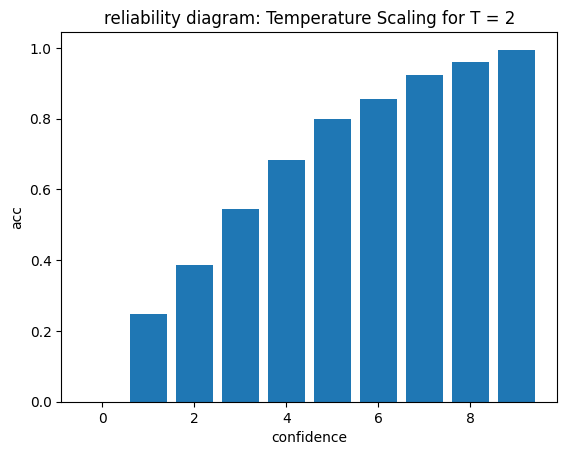

[nan, 0.5915, nan, nan, nan, nan, nan, nan, nan, nan]
[0, 0.5915, 0, 0, 0, 0, 0, 0, 0, 0]


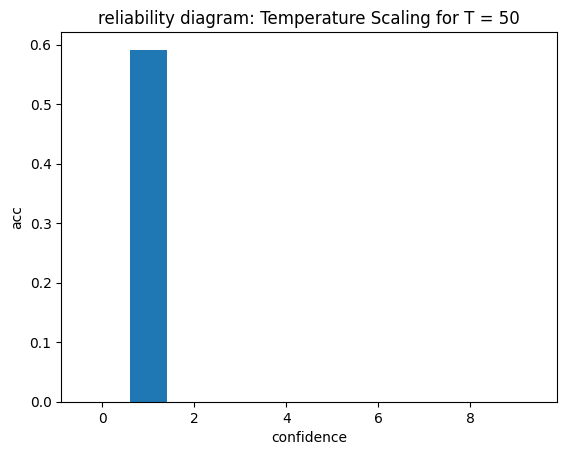

[nan, 0.5915, nan, nan, nan, nan, nan, nan, nan, nan]
[0, 0.5915, 0, 0, 0, 0, 0, 0, 0, 0]


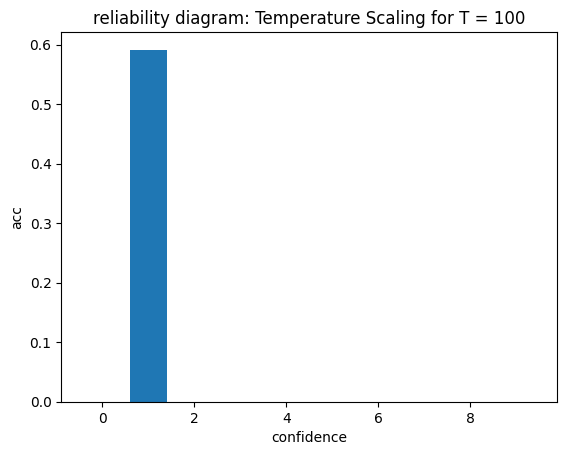

In [31]:
for t_value in T_values:
    histogram_x = temperature_x[t_value]
    
    predicted_confidence = [np.max(x[0]) for x in histogram_x]
    predicted_class = [np.argmax(x[0]) for x in histogram_x]

    bins = [math.floor(item*10) for item in predicted_confidence]
    bins = np.array(bins)
    predicted_class = np.array(predicted_class)

    accs = []

    for bin in range(10):
        idxs = np.argwhere(bins==bin)
        # print("bin idxs: ", bin, idxs)
        # index into y, y_hat to calculate per bin accuracies
        y_preds = predicted_class[idxs]
        y_gt = y_gt_label[idxs]

        equals = y_preds == y_gt
        acc = np.mean(equals)
        accs.append(acc)

    print(accs)
    accs = [0 if math.isnan(x) else x for x in accs]
    print(accs)

    buckets = list(range(10))

    fig, ax = plt.subplots()

    ax.bar(buckets, accs, label=buckets)
    ax.set_ylabel('acc')
    ax.set_xlabel('confidence')
    ax.set_title(f'reliability diagram: Temperature Scaling for T = {t_value}')

    plt.show()